In [2]:
# !pip install tqdm

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 165.2 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 217.9 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 303.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   -------------------- ------------------- 41.0/78.3 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 78.3/78.3 kB 1.4 MB/s eta 0:00:00


In [3]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm, multivariate_normal as mvnorm

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import EllipseCollection

from matplotlib.widgets import Slider
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.animation as animation
plt.style.use(['dark_background'])



# from collections import Counter
from tqdm import tqdm

In [4]:
def gen_hex_grid(nx,ny, phase = 0):
    '''
    Generate a hexagonal grid of cells on [-1,1]
    '''
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,ny)
    dx = 1./(nx-1)

    X,Y = np.meshgrid(x,y)
    for y in range(phase,ny,2):
        X[y] += dx 

    # want to drop every 10th spot
    #   i.e., nx*2
    X,Y = X.flatten(), Y.flatten()
    X = np.delete(X, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    Y = np.delete(Y, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    

    return X,Y

In [5]:
def get_coverage(rf_widths, rf_spacing):
    #inputs are diameters

    return (3*np.pi/4*rf_widths**2) / (3 * np.sqrt(3) / 2 * rf_spacing**2)

In [6]:
def get_response(stim_pos, rf_centers, center_widths, surround_widths, surround_strength):#, SNR):
    '''
    Stimulus position is (2,K)
    RF centers are (2,N)
    RF widths are (N,)
    SNR is (N,)

    returns N,K
    '''

    K = stim_pos.size // 2
    N = rf_centers.size // 2

    #z_c: the normalized distance from the RF center; shape (N,K)
    z = np.linalg.norm(stim_pos.reshape((2,1,-1)) - rf_centers.reshape((2,-1,1)), axis=0)
    
    z_c = z / center_widths.reshape((-1,1))
    z_s = z / surround_widths.reshape((-1,1))
    
    # we want the peak to be 1
    # a*x_c - b*x_s
    # suppose f=.1
    # then we need a = (1+f), b=f

    signal = (1+surround_strength)*np.exp(-(z_c**2) / 2) - surround_strength*np.exp(-(z_s**2) / 2)

    return signal
    # return signal


In [7]:
def gauss2(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    # x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((xy[0]-xo)**2) + 2*b*(xy[0]-xo)*(xy[1]-yo) 
                            + c*((xy[1]-yo)**2)))
    return g.ravel()

In [8]:
def sim(rf_centers, center_width, surround_width, surround_strength, SNR, stim_pos, stimulus_range, X=None, Y=None):
    # nr = np.linalg.norm(np.asarray(stim_pos).reshape((2,1,-1)) - rf_centers.reshape((2,-1,1)), axis=0) / (rf_width / 4)

    
    # target = np.exp(-(nr**2) / 2) # / (2*np.pi) #normalization///
    target = get_response(np.asarray(stim_pos), rf_centers, np.asarray(center_width/4), np.asarray(surround_width/4), surround_strength)


    if X is None or Y is None:
        X,Y = np.meshgrid(stimulus_range,stimulus_range)
    

    signal = get_response(np.stack((X.flatten(), Y.flatten())), rf_centers, np.asarray(center_width/4), np.asarray(surround_width/4), surround_strength)

    
    diff = target[:,None,:] - signal[:,:,None]

    prob = np.prod(norm.pdf(diff, scale=1/SNR), axis=0) #TODO: mvnrand

    return prob,target

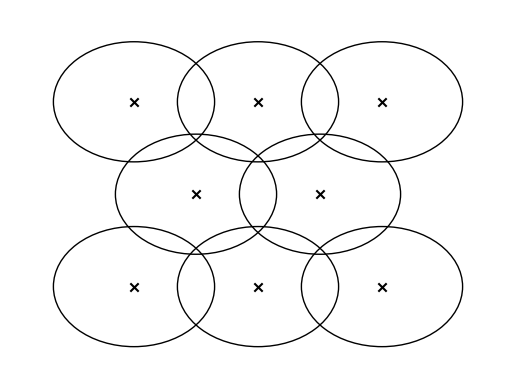

In [36]:
plt.style.use('default')
x,y = gen_hex_grid(3,3, phase=1)

plt.scatter(x,y, c='k', marker='x')
plt.axis('off')
plt.xlim(-2,2)
plt.ylim(-2,2)
# plt.axis('square')

w = 1.3

sc = EllipseCollection(offsets = np.stack((x,y)).T, widths = w, heights = w, angles=0, units='xy', offset_transform=plt.gca().transData, facecolors='None')#, facecolors='None', edgecolors=sig)
# sc.set_array(sig[:,0])
plt.gca().add_collection(sc)


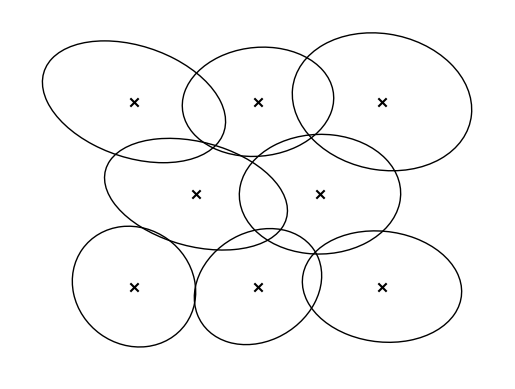

In [37]:
plt.scatter(x,y, c='k', marker='x')
plt.axis('off')
plt.xlim(-2,2)
plt.ylim(-2,2)
# plt.axis('square')

s = .2
n = len(x)

sc = EllipseCollection(offsets = np.stack((x,y)).T, widths = s*np.random.randn(n)+w, heights = s*np.random.randn(n)+w, angles=np.random.rand(n)*360, units='xy', offset_transform=plt.gca().transData, facecolors='None')#, facecolors='None', edgecolors=sig)
# sc.set_array(sig[:,0])
plt.gca().add_collection(sc)

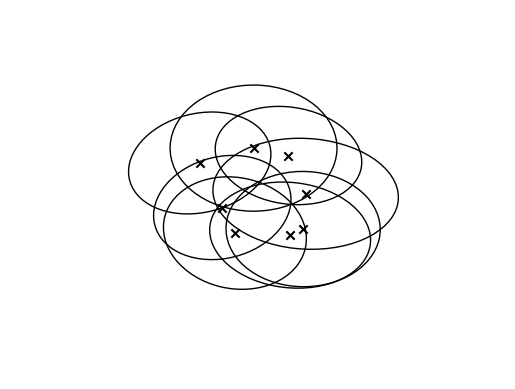

In [54]:
d = 1.0

x = np.random.rand(n)*d - d/2
y = np.random.rand(n)*d - d/2


plt.scatter(x,y, c='k', marker='x')
plt.axis('off')
plt.xlim(-2,2)
plt.ylim(-2,2)
# plt.axis('square')

sc = EllipseCollection(offsets = np.stack((x,y)).T, widths = s*np.random.randn(n)+w, heights = s*np.random.randn(n)+w, angles=np.random.rand(n)*360, units='xy', offset_transform=plt.gca().transData, facecolors='None')#, facecolors='None', edgecolors=sig)
# sc.set_array(sig[:,0])
plt.gca().add_collection(sc)

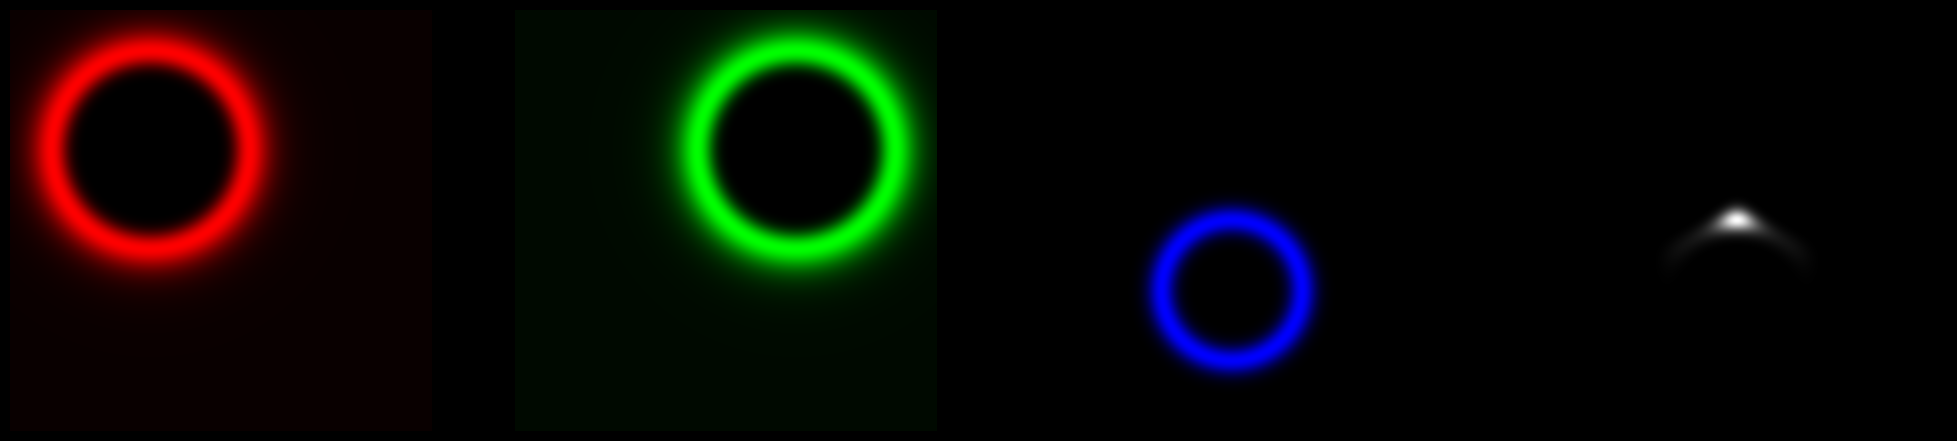

In [8]:
_,axs = plt.subplots(1,4,figsize=(25,7))

stim_range =  np.linspace(-3,3,1000)
cw = 3
sw = 2.5
z = np.zeros((len(stim_range), len(stim_range)))
o = np.ones((len(stim_range), len(stim_range)))


prob, target = sim(np.stack((x[0],y[0])), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
prob = prob - prob.min()
prob = prob / prob.max()
# axs[0].imshow(np.stack((prob.reshape(len(stim_range), len(stim_range)), z, z), axis=-1))
# axs[0].imshow(o, alpha=prob.reshape(len(stim_range), len(stim_range)), cmap='Reds')
axs[0].imshow(np.stack((o, z, z, prob.reshape(len(stim_range), len(stim_range))), axis=-1))
axs[0].axis('off')

a = prob.reshape(len(stim_range), len(stim_range))

prob, target = sim(np.stack((x[1],y[1])), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
prob = prob / prob.max()
axs[1].imshow(np.stack((z, o, z, prob.reshape(len(stim_range), len(stim_range))), axis=-1))
axs[1].axis('off')

b = prob.reshape(len(stim_range), len(stim_range))


prob, target = sim(np.stack((x[2],y[2])), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
prob = prob / prob.max()
axs[2].imshow(np.stack((z, z, o, prob.reshape(len(stim_range), len(stim_range))), axis=-1))
axs[2].axis('off')

c = prob.reshape(len(stim_range), len(stim_range))

# axs[3].imshow(prob.reshape(len(stim_range), len(stim_range)), cmap='gray')
# axs[3].imshow(np.stack((a,b,c), axis=-1), cmap='gray')

axs[3].imshow(np.stack((o, o, o, a*b*c), axis=-1))
# axs[3].imshow(a*b*c, cmap='gray')


# prob, target = sim(np.stack((x,y)), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
# axs[3].imshow(prob.reshape(len(stim_range), len(stim_range)), cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.savefig(r'C:\Users\zfj\Downloads\test.svg', transparent=True)

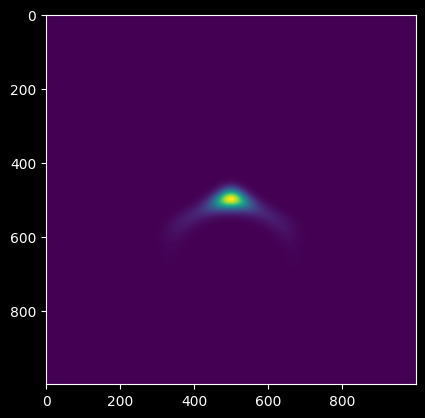

In [11]:
prob, target = sim(np.stack((x,y)), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
target.shape,prob.shape
plt.imshow(prob.reshape((len(stim_range),-1)))

In [25]:
mvnorm.pdf([.15, 0], mean=[.3, .3], cov=[[.1, 0,],[0,.1]])

0.9068375304478942

In [30]:
np.stack((x,y)).shape

(2, 3)

In [167]:
from scipy.integrate import dblquad



def bayes(rf_centers, center_widths, surround_widths, surround_strength, SNR, stim_pos, X=[-3, 3], Y = [-3, 3], target=None, weight=True):

    #get the mean response of the cells to the stimulus at stim_pos
    if target is None:
        target = get_response(stim_pos, rf_centers, center_widths, surround_widths, surround_strength)
    var = 1/SNR
    
    # the probability of the target response at a given stim position
    def f(x,y):
        signal = get_response(np.stack((x,y)), rf_centers, center_widths, surround_widths, surround_strength)
        diff = target - signal
        prob = np.prod(norm.pdf(diff, scale=var), axis=0)

        return prob
    
    if weight:
        # the probability of the response is the sum of the probability of the response at all stim positions
        p_y, _ = dblquad(f, *X, *Y)
    else:
        p_y = None

    # finally, we get the probability of the response at the true stimulus position
    X,Y = np.meshgrid(np.linspace(*Y, 1000), np.linspace(*X, 1000))
    p_y_x = f(X.flatten(), Y.flatten()).reshape(X.shape)

    return p_y_x, p_y, target

# p = np.empty((10,10)) * np.nan
# X = Y = np.linspace(-3,3,10)


# def sim(rf_centers, center_width, surround_width, surround_strength, SNR, stim_pos, stimulus_range, X=None, Y=None):
#     target = get_response(np.asarray(stim_pos), rf_centers, np.asarray(center_width/4), np.asarray(surround_width/4), surround_strength)

#     if X is None or Y is None:
#         X,Y = np.meshgrid(stimulus_range,stimulus_range)
    

#     signal = get_response(np.stack((X.flatten(), Y.flatten())), rf_centers, np.asarray(center_width/4), np.asarray(surround_width/4), surround_strength)
#     diff = target - signal
 
#     prob = np.prod(norm.pdf(diff, scale=1/SNR), axis=0) #TODO: mvnrand

#     return prob,target

cell_pos = np.stack(gen_hex_grid(2,2, phase=1))
p, w, y = bayes(cell_pos, np.asarray(cw/4), np.asarray(sw/4), .9, 10, np.asarray([0,0]))


In [106]:
y.shape

(3, 1)

In [108]:
# y

p_i = np.ones((100,*p.shape))
y_i = np.empty((100,y.shape[0],1)) * np.nan
w_i = np.empty(100) * np.nan
for i in range(100):
    y_i[i] = y + norm.rvs(scale = 1/.9, size=3)[:,None]
    p_i[i], w_i[i], _ = bayes(cell_pos, np.asarray(cw/4), np.asarray(sw/4), .9, 10, np.asarray([0,0]), target=y_i[i])


    # y.shape
    # norm.rvs()



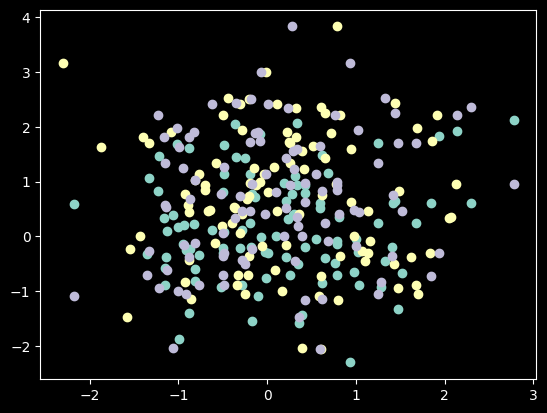

In [118]:
plt.scatter(y_i[:,0], y_i[:,1])
plt.scatter(y_i[:,1], y_i[:,2])
plt.scatter(y_i[:,0], y_i[:,2])


(0.0, 0.01)

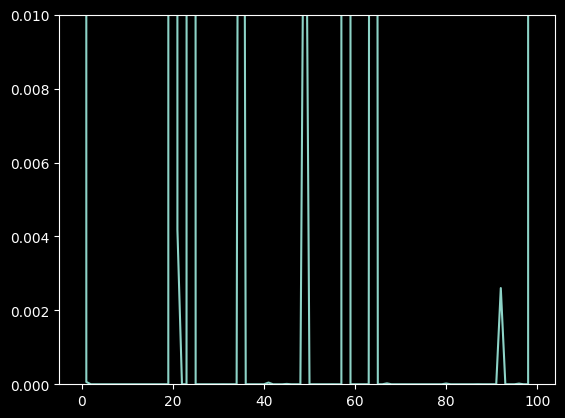

In [134]:
plt.plot(w_i)
plt.ylim([0, .01])

In [165]:
stim_pos

array([[-1.,  1.,  0.],
       [-1., -1.,  1.]])

In [257]:
import tqdm

def get_ci(p, ci=0.95):
    #gets the confidence interval of the probability map in terms of the minimal area

    tp = (p.flatten()/p.sum())
    tp[::-1].sort() # bizarrely this works, quickly
    tps = np.cumsum(tp)

    i = np.argmax(tps>ci)
    return i / len(tp), tp[i] * p.sum()


q = 20
ci = np.empty((q,q)) * np.nan
e = 3

cell_pos = np.stack(gen_hex_grid(2,2, phase=1))
with tqdm.tqdm(total=q*q) as pbar:
    for i,x in enumerate(np.linspace(-e,e,q)):
        for j,y in enumerate(np.linspace(-e,e,q)):
            p, w, _ = bayes(cell_pos, np.asarray(cw/4), np.asarray(sw/4), .9, 10, np.asarray([x,y]), weight=False)

            ci[j,i],_ = get_ci(p)
            pbar.update()



100%|██████████| 400/400 [09:48<00:00,  1.47s/it]


31321


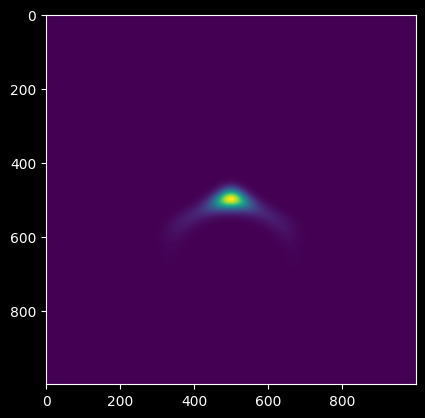

106.18643981224722


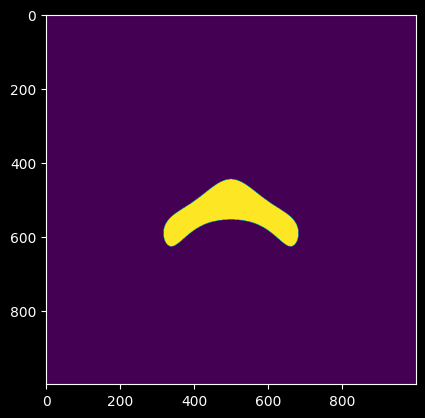

In [258]:

cw = 3
sw = 2.5

p, _, _ = bayes(cell_pos, np.asarray(cw/4), np.asarray(sw/4), .9, 10, np.asarray([0,0]), weight=False)
_, th = get_ci(p)
plt.imshow(p > th)
print(np.count_nonzero(p>th))


# p, _, _ = bayes(cell_pos, np.asarray(1), np.asarray(3), .6, 100, np.asarray([0,0]), weight=False)

plt.imshow(p)
plt.show()
# _, th = get_ci(p)
plt.imshow(p > th)
print(np.sqrt(np.count_nonzero(p>th)/p.size * 600*600))

In [233]:
np.sqrt(31321/p.size * 600 * 600)

106.18643981224722

In [253]:
# 600*600
ci.shape

(20, 20)

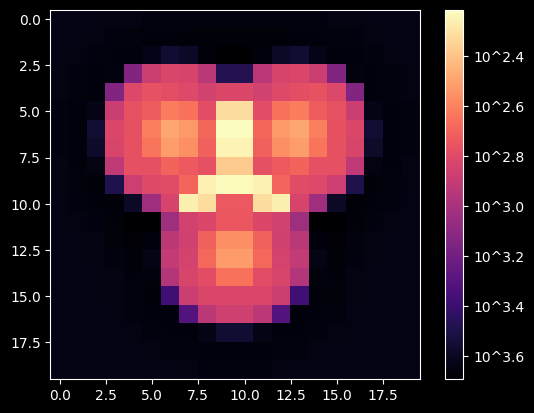

In [259]:
plt.imshow(-np.log10(ci*10000), cmap='magma')

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: f"10^{-x:0.1f}"
# fmt = lambda x, pos: f'{x}'
cbar = plt.colorbar(format=FuncFormatter(fmt))


# plt.imshow(ci, cmap='magma')
# plt.colorbar()

# ci
# plt.imshow(p)
# print(get_ci(p))

10.806823373276256


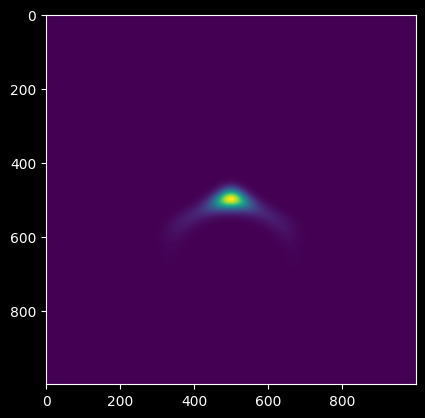

4.304358101928344


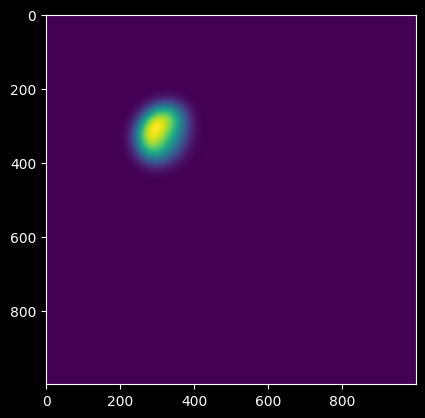

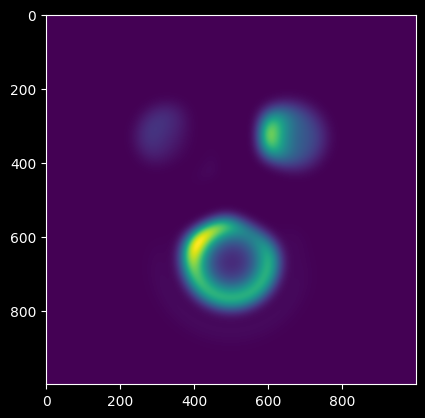

In [138]:
plt.imshow(p)
print(w)
plt.show()

plt.imshow(p_i[0])
print(w_i[0])
plt.show()

plt.imshow(np.einsum('ijk,i', p_i, w_i))
plt.show()



In [264]:
# cell_pos.shape
plt.style.use('default')

In [296]:
cw, sw

(3, 2.5)

([], [])

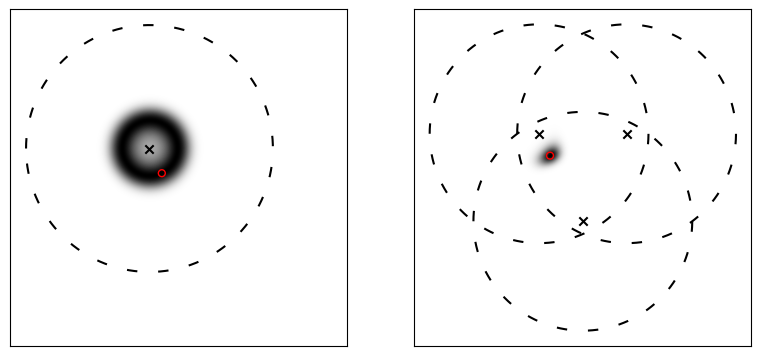

In [377]:
#  sim(rf_centers, center_width, surround_width, surround_strength, SNR, stim_pos, stimulus_range, X=None, Y=None):

fig = plt.figure(figsize=(20,7))
fig.add_subplot(1,4,1)

stim_pos = np.asarray([-.75, -.5])

cell_pos = np.stack(gen_hex_grid(2,2, phase=1))

cw = 5
sw = cw * 3

SNR = 10

th = np.linspace(-np.pi, np.pi, 300)


prob, target = sim(cell_pos[:,0], cw, sw, .6, SNR, stim_pos, stim_range)
prob = prob - prob.min()
prob = prob / prob.max()
plt.imshow(-prob.reshape(len(stim_range), len(stim_range)), cmap='gray', extent=[-3, 3, 3, -3])
plt.scatter(*cell_pos[:,0], c='k', marker='x')

plt.scatter(*stim_pos, s=25, edgecolor='r', facecolor='none')

i = 0
plt.plot(2.5 * np.cos(th) + cell_pos[0,i], 2.5 * np.sin(th) + cell_pos[1,i], c='k', linestyle=(0, (5, 10)))
# plt.axis('off')
plt.xticks([])
plt.yticks([])

fig.add_subplot(1,4,2)

prob, target = sim(cell_pos, cw, sw, .6, SNR, stim_pos, stim_range)
prob = prob - prob.min()
prob = prob / prob.max()
im = plt.imshow(-prob.reshape(len(stim_range), len(stim_range)), cmap='gray', extent=[-3, 3, 3, -3])
plt.scatter(*cell_pos, c='k', marker='x')

plt.scatter(*stim_pos, s=25, edgecolor='r', facecolor='none')
for i in range(3):
    plt.plot(2.5 * np.cos(th) + cell_pos[0,i], 2.5 * np.sin(th) + cell_pos[1,i], c='k', linestyle=(0, (5, 10)))

plt.xticks([])
plt.yticks([])
# plt.axis('off')


# plt.colorbar(im)

In [682]:
sl = 6
cell_pos = np.stack(gen_hex_grid(sl,sl, phase=1))

# stim_pos = np.asarray([-.75, -.5])
# stim_pos = np.asarray([-.75, -.5])

#11.29, .38
#18.33, .55
#3,36, .18

cw = .55
sw = cw * 3
SNR = 18.33

X, Y = np.meshgrid(np.linspace(-1, 1, 30), np.linspace(-1, 1, 30))
stim_pos = np.stack((X.flatten(), Y.flatten()))

# plt.scatter(*cell_pos)
# plt.axis('square')
stim_range =  np.linspace(-1, 1, 20)
prob, target = sim(cell_pos, cw, sw, .6, SNR, stim_pos, stim_range)

In [683]:
prob = prob / prob.sum(axis=0, keepdims=True)

# tprob = np.flip(np.sort(prob,axis=0),axis=0)
# tprob = np.cumsum(np.flip(np.sort(prob,axis=0), axis=0), axis=0)
tprob = np.argmax(np.cumsum(np.flip(np.sort(prob,axis=0), axis=0), axis=0) > .95, axis=0)
# tprob = np.argmax(np.cumsum(prob.sort(axis=0), axis=0) > .95, axis=0)

C:\Users\zfj\AppData\Local\Temp\ipykernel_29772\2669506073.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(-np.log10(tprob.reshape(X.shape)), extent=[1, -1, 1, -1], cmap='magma')


(0.43555555555555553, 0.5899738433205909)

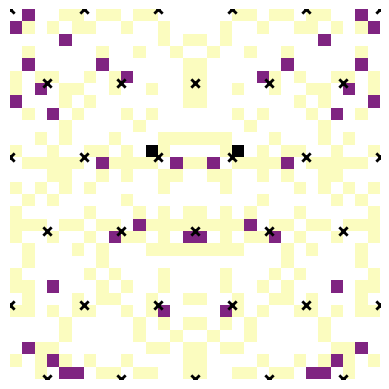

In [685]:

# plt.imshow(-np.log10(tprob.reshape(X.shape)), extent=[.25, -.25, .25 ,-.25], cmap='magma')
plt.imshow(-np.log10(tprob.reshape(X.shape)), extent=[1, -1, 1, -1], cmap='magma')
# plt.imshow(tprob.reshape(X.shape), extent=[1, -1, 1, -1], cmap='magma')
# plt.colorbar()
plt.scatter(*cell_pos, c='k', marker='x', linewidth=2)
plt.axis('off')
tprob.mean(), tprob.std()

In [585]:
cell_pos[:,:2]

array([[-1. , -0.6],
       [-1. , -1. ]])

In [614]:
import tqdm

sl = 6
cell_pos = np.stack(gen_hex_grid(sl,sl, phase=1))
X, Y = np.meshgrid(np.linspace(-.25, .25, 10), np.linspace(-.25, .25, 10))
stim_pos = np.stack((X.flatten(), Y.flatten()))

stim_range =  np.linspace(-.5, .5, 100)

# cws = np.linspace(.1,2,20)
cws = np.logspace(np.log10(.01), np.log10(10), 20) * .4
snrs = np.logspace(0,2, 20)

me = np.empty((len(cws), len(snrs))) * np.nan
se = np.empty((len(cws), len(snrs))) * np.nan


with tqdm.tqdm(total=len(cws)*len(snrs)) as pbar:
    for i,cw in enumerate(cws):
        sw = cw * 3
        for j, snr in enumerate(snrs):
            prob, _ = sim(cell_pos, cw, sw, .6, snr, stim_pos, stim_range)
            prob = prob / prob.sum(axis=0, keepdims=True)
            tprob = np.argmax(np.cumsum(np.flip(np.sort(prob,axis=0), axis=0), axis=0) > .95, axis=0)


            me[i,j] = tprob.mean()
            se[i,j] = tprob.std()     
            pbar.update()  


100%|██████████| 400/400 [07:26<00:00,  1.12s/it]


In [686]:
# cws
# np.logspace(0,2)
# cws * .4 / .4
snrs

array([  1.        ,   1.27427499,   1.62377674,   2.06913808,
         2.6366509 ,   3.35981829,   4.2813324 ,   5.45559478,
         6.95192796,   8.8586679 ,  11.28837892,  14.38449888,
        18.32980711,  23.35721469,  29.76351442,  37.92690191,
        48.32930239,  61.58482111,  78.47599704, 100.        ])

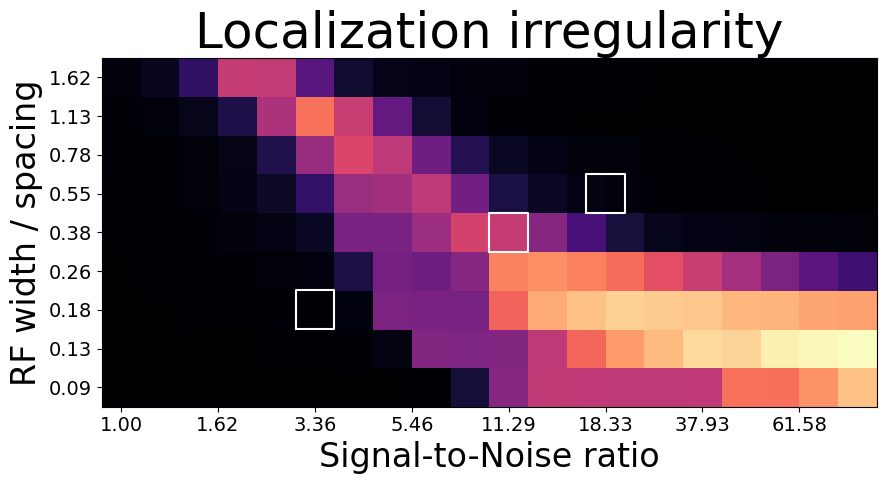

In [698]:
from matplotlib.ticker import FuncFormatter

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.imshow(-np.log10(me), aspect=1/2)
# plt.subplot(1,2,2)

plt.figure(figsize=(10,10))

plt.imshow(se, aspect = len(snrs) / len(cws), cmap='magma')

plt.xlabel('Signal-to-Noise ratio', fontsize=24)
plt.ylabel('RF width / spacing', fontsize=24)


plt.ylim([5.5, 14.5])

# plt.yticks([.1, .2, .5, 1])
# plt.xticks([1, 2, 5, 10, 20, 50, 100])
# plt.yticks([.01, .05, .1, .5, 1, 5, 10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


fmt = lambda x, pos: f"{snrs[np.clip(x,0,len(snrs)-1).astype(int)]:0.2f}"
plt.gca().xaxis.set_major_formatter(fmt)

fmt = lambda x, pos: f"{cws[np.clip(x,0,len(cws)-1).astype(int)]/.4:0.2f}"
plt.gca().yaxis.set_major_formatter(fmt)

plt.title('Localization irregularity', fontsize=36)#, fontweight='bold')

plt.plot(np.array([0,1,1,0,0])+4.5, np.array([0,0,1,1,0])+7.5, c='w')
plt.plot(np.array([0,1,1,0,0])+9.5, np.array([0,0,1,1,0])+9.5, c='w')
plt.plot(np.array([0,1,1,0,0])+12, np.array([0,0,1,1,0])+10.5, c='w')


#11.29, .38
#18.33, .55
#3.36, .18


# plt.colorbar()
# cbar = plt.colorbar()

#10 SNRs, 20 center sizes...


C:\Users\zfj\AppData\Local\Temp\ipykernel_29772\3854603580.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(-np.log10(me / cws[:,None]), aspect = 1/2)


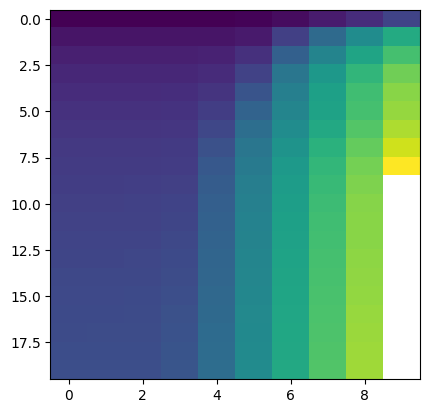

In [552]:
me.shape, cws.shape
plt.imshow(-np.log10(me / cws[:,None]), aspect = 1/2)

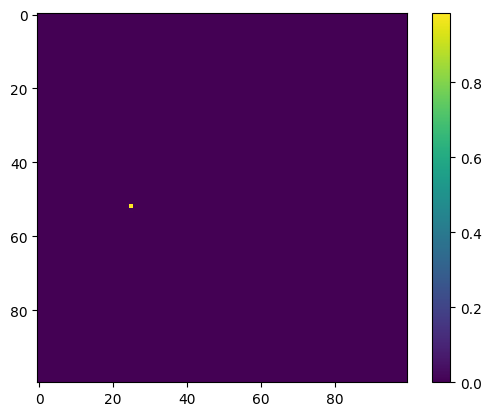

In [535]:
plt.imshow(prob[:,50].reshape(len(stim_range),-1))
prob.min(), prob.max()
plt.colorbar()

In [1]:
#area cap: 2*pi*r**2*(1-cos(th))


#area sphere: 4*pi*r**2
# prop: ~1-cos(th)
#na = n*sin(th)

def f(na, n=1):
    return 1-np.cos(np.arcsin(na/n))/2

# f(.8, 1.3333) / f(1, 1.3333), 

f(.45, 1.0) / f(.28, 1.0)

NameError: name 'np' is not defined

: 

27

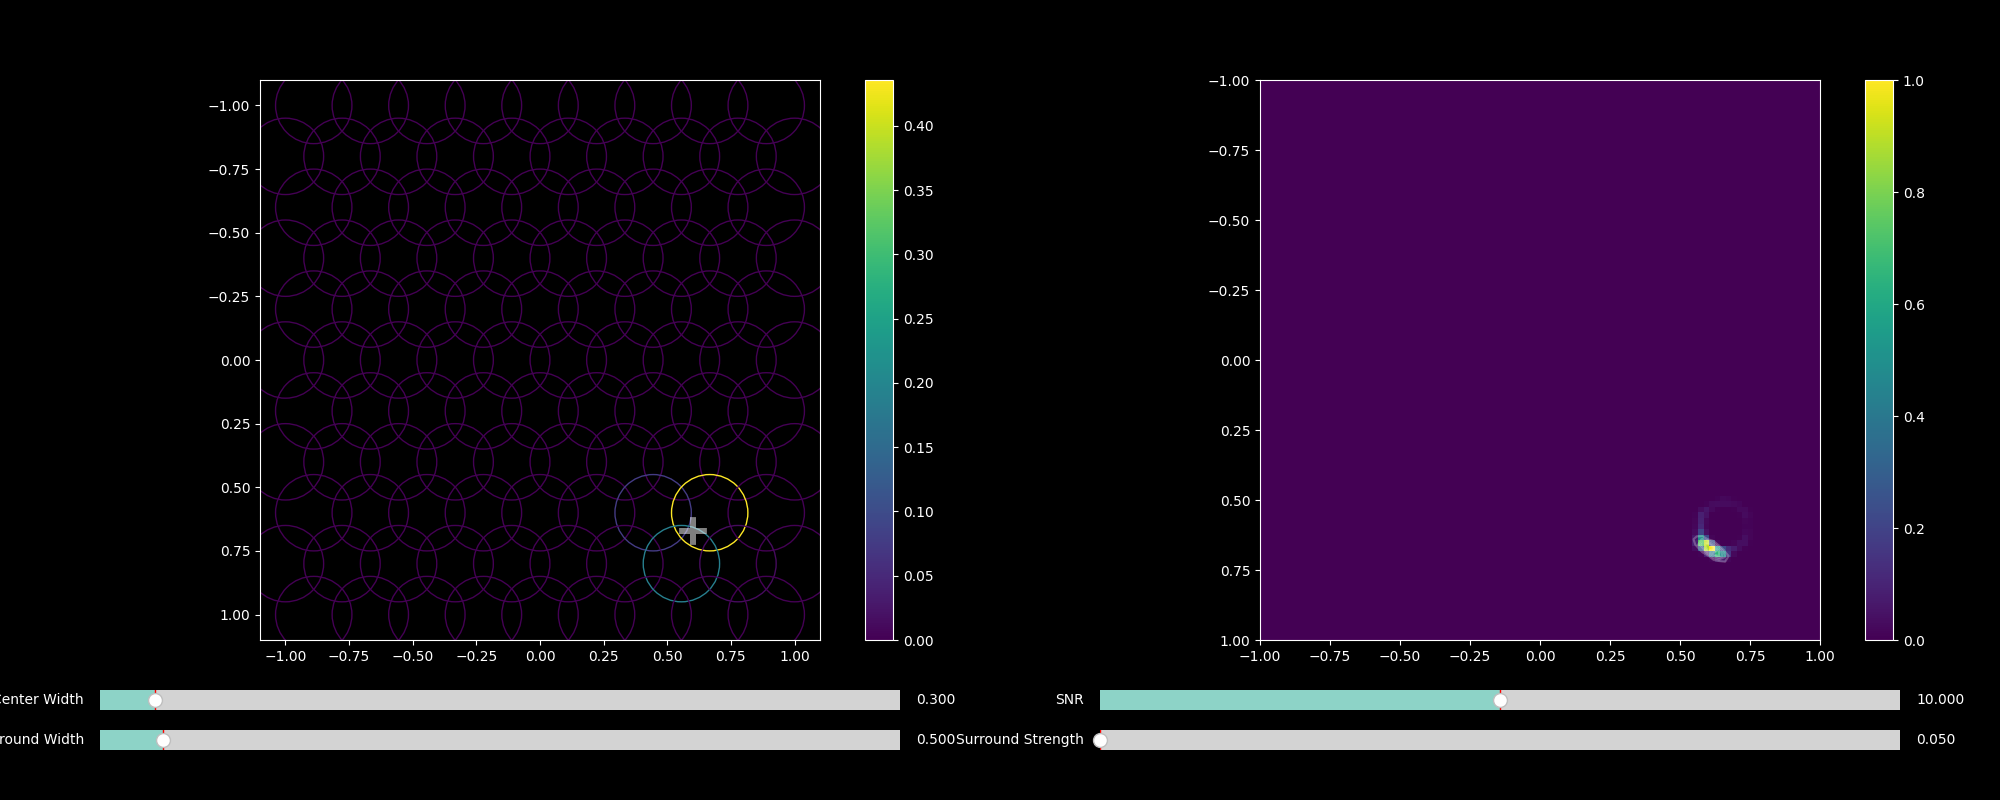

In [ ]:
# %matplotlib widget
def fit(rf_centers, cw, sw, ss, SNR, stim_pos, X, Y):
    N_s, sig = sim(rf_centers, cw, sw, ss, SNR, stim_pos, None, X=X, Y=Y)
    N_s = N_s.reshape(X.shape)
    N_s = N_s / N_s.max()

    cy,cx = xyrange[np.argwhere(N_s == 1)[0]]    

    
    N_x = N_s.mean(axis=0)
    sx = np.count_nonzero(N_x > N_x.max()/2) / len(xyrange) * (xyrange[-1] - xyrange[0])

    N_y = N_s.mean(axis=1)
    sy = np.count_nonzero(N_y > N_y.max()/2) / len(xyrange) * (xyrange[-1] - xyrange[0])

    try:
        popt, _ = curve_fit(gauss2, (X.flatten(), Y.flatten()), N_s.flatten(), p0=(1.0,cx,cy,sx,sy,0,0), maxfev=10000)
        f = gauss2((X,Y), *popt)
    except RuntimeError:
        f = None

    return N_s, f, sig


xyrange = np.linspace(-1,1,101)
X,Y = np.meshgrid(xyrange, xyrange)
rf_centers = np.stack((x,y))
cw = .3
sw = .5
ss = 0.0#.1
stim_pos = (.6, .67)
SNR = 10

plt.close('all')
# fig, axs = plt.subplots(1,2,figsize=(20,13))
fig = plt.figure(figsize=(20,8))
axs = []
axs.append(fig.add_axes([.05,.2,.45,.7]))
axs.append(fig.add_axes([.55,.2,.45,.7]))
# axs = axs.flatten()
    
N_s, f, sig = fit(rf_centers, cw, sw, ss, SNR, stim_pos, X,Y)
# sc = axs[0].scatter(*rf_centers,c=sig)
# n = mpl.colors.Normalize(vmin = min(sig), vmax = max(sig))
# m = mpl.cm.ScalarMappable(norm=n, cmap='magma')
sc = EllipseCollection(offsets = rf_centers.T, widths = cw, heights = cw, angles=0, units='xy', offset_transform=axs[0].transData, facecolors='None')#, facecolors='None', edgecolors=sig)
sc.set_array(sig[:,0])
axs[0].add_collection(sc)

axs[0].axis('square')
# axs[0].set_xlim([-1.1, 1.1])
# axs[0].set_ylim([-1.1, 1.1])

p0 = axs[0].plot(*stim_pos, marker='+', mew=20, ms=5, color='w', alpha=.5)
axs[0].invert_yaxis()

# p1 = axs[1].plot(*stim_pos, marker='+', mew=20, ms=5, color='w', alpha=.5)

im = axs[1].imshow(N_s, extent=(xyrange[0],xyrange[-1],xyrange[-1],xyrange[0]))
ct = axs[1].contour(X,Y, f.reshape(X.shape), 8, colors='w', alpha=.25)

cb1 = fig.colorbar(sc, ax=axs[0])
fig.colorbar(im, ax=axs[1])

# print(sc)



wax = fig.add_axes([.05, .1, .4, .05])
sax = fig.add_axes([.55, .1, .4, .05])

swax = fig.add_axes([.05, .05, .4, .05])
scax = fig.add_axes([.55, .05, .4, .05])

w_slider = Slider(
    ax=wax,
    label='Center Width',
    valmin=.1,
    valmax=3,
    valinit=cw,
    valfmt='%0.03f'
)
snr_slider = Slider(
    ax=sax,
    label='SNR',
    valmin=-1,
    valmax=3,
    valinit=np.log10(SNR),
    # valfmt='%0.0f'
)
snr_slider.valtext.set_text(f'{SNR:0.03f}')

sw_slider = Slider(
    ax=swax,
    label='Surround Width',
    valmin=.2,
    valmax=4,
    valinit=sw,
    valfmt='%0.03f'
)

sc_slider = Slider(
    ax=scax,
    label='Surround Strength',
    valmin=.05,
    valmax=.9,
    valinit=ss,
    valfmt='%0.03f'
)

def redraw():
    global ct
    global sc
    N_s, f, sig = fit(rf_centers, cw, sw, ss, SNR, stim_pos, X,Y)
    
    sc.remove()
    # sc = axs[0].scatter(*rf_centers,c=sig)
    sc = EllipseCollection(offsets = rf_centers.T, widths = cw, heights = cw, angles=0, units='xy', offset_transform=axs[0].transData, facecolors='None')#, facecolors='None', edgecolors=sig)
    sc.set_array(sig[:,0])
    axs[0].add_collection(sc)


    p0[0].set_data([stim_pos[0]], [stim_pos[1]])
    # p1[0].set_data([stim_pos[0]], [stim_pos[1]])
    im.set_data(N_s)
    if ct is not None:
        for coll in ct.collections:        
            coll.remove()
            ct = None
    if f is not None:
        ct = axs[1].contour(X,Y, f.reshape(X.shape), 8, colors='w', alpha=.25)

    

def onclick(event):
    global stim_pos
    if event.inaxes == axs[0] or event.inaxes == axs[1]:
        stim_pos = (event.xdata, event.ydata)
        redraw()

def update_snr(_):
    global SNR
    SNR = 10 ** snr_slider.val
    snr_slider.valtext.set_text(f'{SNR:0.02f}')
    redraw()

def update_w(_):
    global cw
    cw =  w_slider.val
    redraw()

def update_sw(_):
    global sw
    sw =  sw_slider.val
    redraw()

def update_ss(_):
    global ss
    ss =  sc_slider.val
    redraw()

snr_slider.on_changed(update_snr)
w_slider.on_changed(update_w)
sw_slider.on_changed(update_sw)
sc_slider.on_changed(update_ss)

fig.canvas.mpl_connect('button_press_event', onclick)

In [131]:
# for w, snr
    #for true_stim_pos in range:
        # generate_prob_map
        # normalize to sum 1 over (-1,1)X(-1,1)
        # convert to cdf over distance from true_stim_pos
        # append(where(cdf == 0.5))
    #get mean, std over range
ws = np.linspace(0.2, 1.0, 20)
snrs = np.logspace(-1, 3, 20)

rf_centers = np.stack((x,y))
testrange = np.linspace(-2,2,101)
X,Y = np.meshgrid(testrange, testrange)

stimrange = np.linspace(-0.5,0,5,11)
sX,sY = np.meshgrid(stimrange, stimrange)

d = np.empty(sX.size)

mu = np.empty((len(ws), len(snrs))) * np.nan
sig = np.empty_like(mu) * np.nan

with tqdm(total=mu.size) as pbar:
    for i,w in enumerate(ws):
        for j,snr in enumerate(snrs):
            for k,(sx,sy) in enumerate(zip(sX.flatten(), sY.flatten())):
                prob,_ = sim(rf_centers, w, snr, (sx, sy), None, X=X, Y=Y)
                prob /= prob.sum()
                r = ((X - sx)**2 + (Y-sy)**2).flatten()
                ri = np.argsort(r)
                pi = np.nonzero(np.cumsum(prob[ri])>.5)[0]
                if len(pi):
                    d[k] = r[ri][pi[0]]
                else:
                    # print('!', w, snr, (sx,sy))
                    d[k] = np.nan
            mu[i,j] = np.nanmean(d)
            sig[i,j] = np.nanstd(d)
            pbar.update()




  4%|▍         | 18/400 [00:40<13:45,  2.16s/it]C:\Users\zfj\AppData\Local\Temp\ipykernel_30524\4122711095.py:28: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum()
100%|██████████| 400/400 [12:05<00:00,  1.81s/it]


(0.16, 1.04) [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]


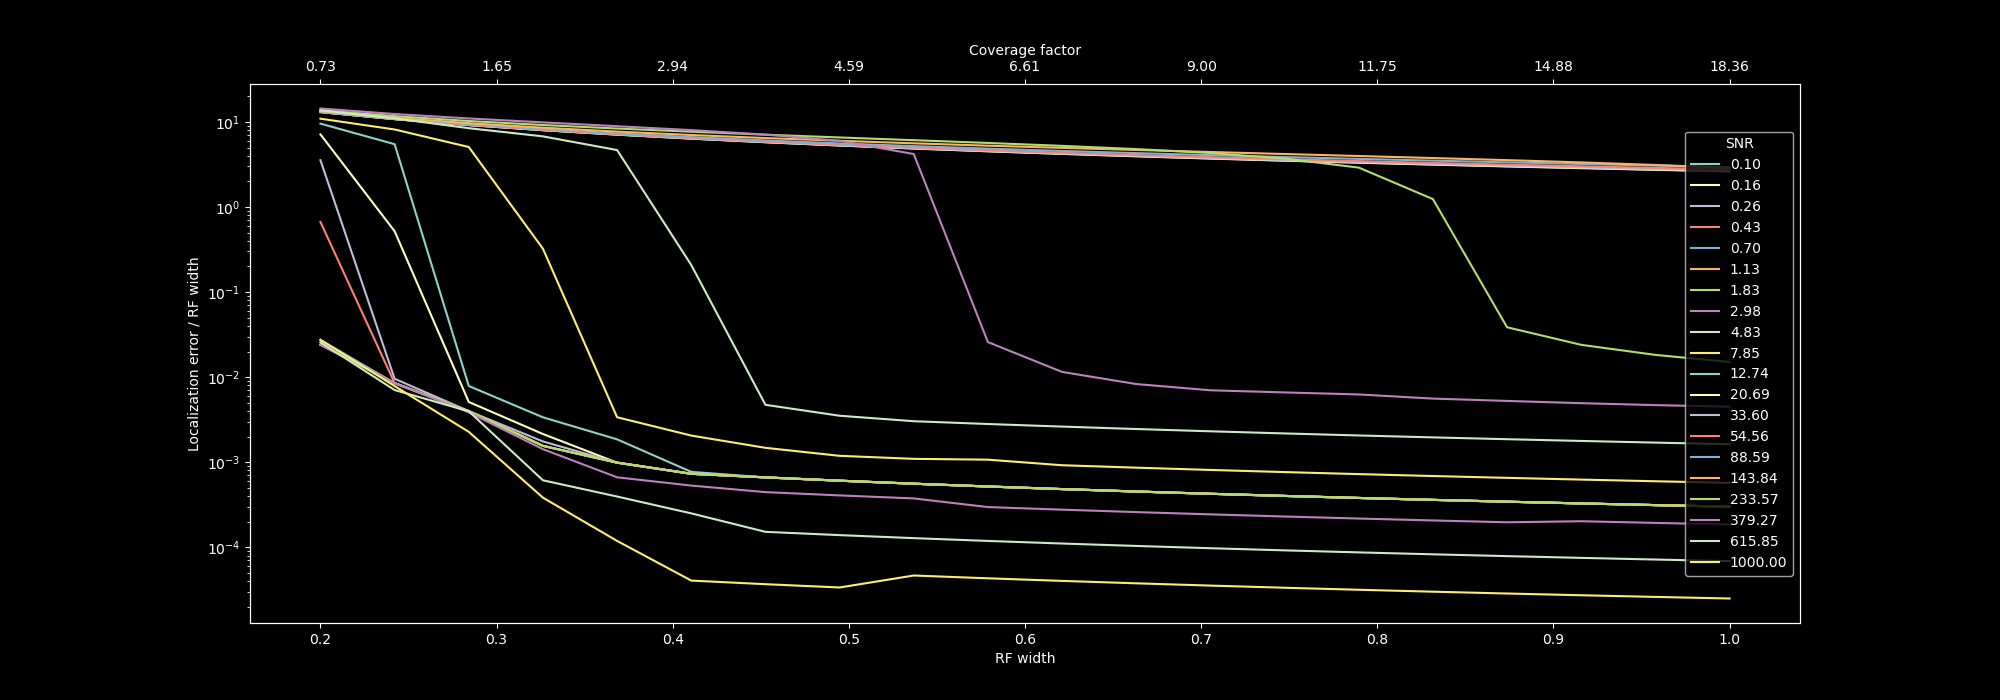

In [132]:
plt.close('all')
# _,axs = plt.subplots(2,1,figsize=(20,13))
_,axs = plt.subplots(1,1,figsize=(20,7))

# plt.sca(axs[0])
# for j,snr in enumerate(snrs):
#     plt.plot(get_coverage(ws, 2/9), mu[:,j] / ws, label=snr)
# plt.legend(loc='right', title='SNR')

# plt.yscale('log')
# plt.xlabel('Coverage factor')
# plt.ylabel('Localization error / RF width')

# plt.sca(axs[1])
for j,snr in enumerate(snrs):
    # plt.plot(ws, mu[:,j] / ws, label=f"{snr:0.2e}")
    plt.plot(ws, mu[:,j] / ws, label=f"{snr:0.2f}")
plt.legend(loc='right', title='SNR')

plt.yscale('log')
plt.xlabel('RF width')
plt.ylabel('Localization error / RF width')
xl, xt = plt.xlim(), plt.xticks()[0]

print(xl, xt)
plt.twiny()
# plt.xlim(get_coverage(np.asarray(xl), 2/9))
plt.xticks(ticks=xt, labels=[f"{get_coverage(xtt, 2/9):0.02f}" for xtt in xt])
plt.xlabel('Coverage factor')
plt.xlim(xl)
plt.show()

Text(0.5, 0.98, 'SNR = 2.98')

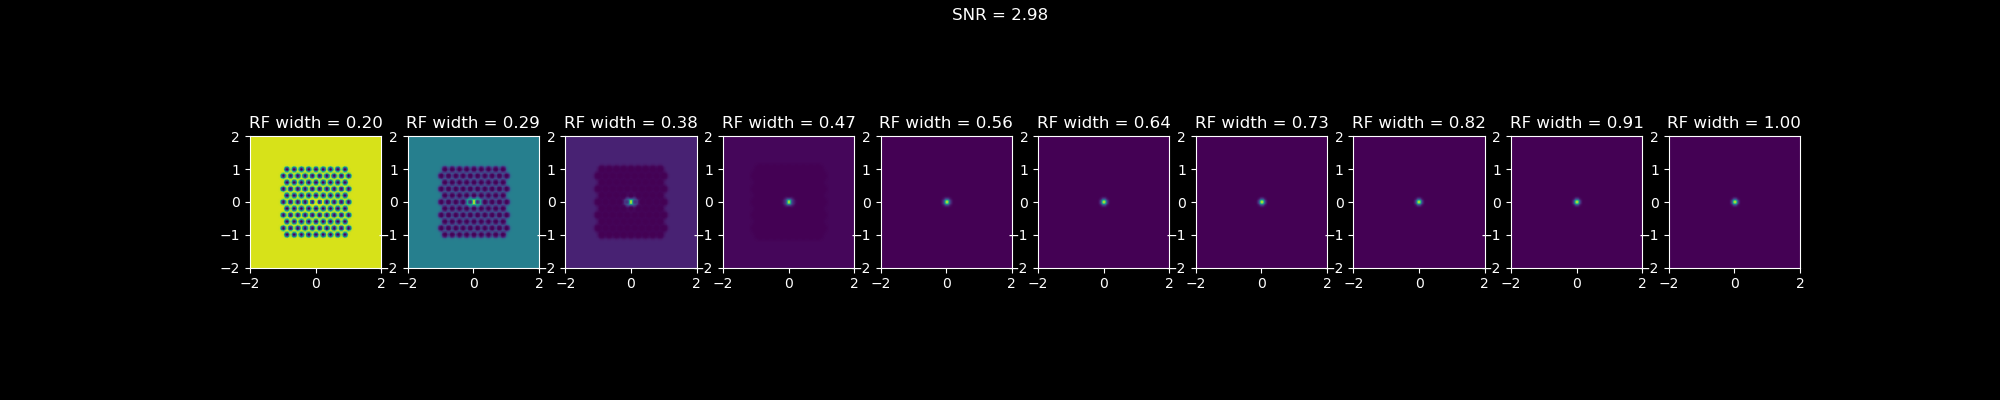

In [161]:
plt.close('all')
ncols = 10
_,axs = plt.subplots(1,ncols, figsize=(20,4))
for i,w in enumerate(np.linspace(0.2, 1.0, ncols)):
    prob,_ = sim(rf_centers, w, 2.98, (0,0), None, X=X, Y=Y)
    prob /= prob.sum()
    im = axs[i].imshow(prob.reshape(X.shape), extent=[-2,2,-2,2])
    axs[i].set_title(f'RF width = {w:0.02f}')
    # im.set_clim(0.0001,0.05)

    # print(im.get_clim())

    # prob,_ = sim(rf_centers, w, snr, stim_pos, (sx, sy), X=X, Y=Y)
plt.gcf().suptitle(f"SNR = 2.98")
                